In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "gpu"

import jax
import jax.numpy as jnp
import optax
import flax.linen as nn
from flax.training import train_state
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Custom dataset class for amplitude and phase spectra including labels
class SpectrumDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        amp_spectrum = self.get_amplitude_spectrum(image)
        phase_spectrum = self.get_phase_spectrum(image)
        return {
            'image': torch.tensor(image, dtype=torch.float32).unsqueeze(0),
            'amplitude': torch.tensor(amp_spectrum, dtype=torch.float32).unsqueeze(0),
            'phase': torch.tensor(phase_spectrum, dtype=torch.float32).unsqueeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

    def get_amplitude_spectrum(self, image):
        F = np.fft.fft2(image)
        F_shifted = np.fft.fftshift(F)
        amplitude_spectrum = np.abs(F_shifted)
        return amplitude_spectrum #np.log1p(amplitude_spectrum)  # Log scaling for visualization

    def get_phase_spectrum(self, image):
        F = np.fft.fft2(image)
        F_shifted = np.fft.fftshift(F)
        phase_spectrum = np.angle(F_shifted)
        return phase_spectrum

# Load MNIST dataset
train_data = torchvision.datasets.MNIST('./data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST('./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)

# Convert images and labels to numpy arrays and normalize images to [0, 1]
train_images = train_data.data.numpy().astype(np.float32) / 255.0
test_images = test_data.data.numpy().astype(np.float32) / 255.0
train_labels = train_data.targets.numpy()
test_labels = test_data.targets.numpy()

# Create spectrum datasets for training and test data
train_spectrum_dataset = SpectrumDataset(train_images, train_labels)
test_spectrum_dataset = SpectrumDataset(test_images, test_labels)

# Create DataLoader objects for the new datasets
train_loader = torch.utils.data.DataLoader(train_spectrum_dataset, batch_size=64, shuffle=True) #batch_size=128
test_loader = torch.utils.data.DataLoader(test_spectrum_dataset, batch_size=64, shuffle=True)

In [3]:

# Define the model components
class Encoder1(nn.Module):
    latent_dims: int = 2

    def setup(self):
        self.dense1 = nn.Dense(512)
        self.dense2 = nn.Dense(self.latent_dims)

    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))
        x = nn.sigmoid(self.dense1(x))
        return self.dense2(x)

class Encoder2(nn.Module):
    latent_dims: int = 2

    def setup(self):
        self.dense1 = nn.Dense(512)
        self.dense2 = nn.Dense(self.latent_dims)

    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))
        x = nn.sigmoid(self.dense1(x))
        return self.dense2(x)

class Decoder(nn.Module):
    latent_dims: int = 4

    def setup(self):
        self.dense1 = nn.Dense(512)
        self.dense2 = nn.Dense(784)

    def __call__(self, z):
        z = nn.sigmoid(self.dense1(z))
        z = nn.sigmoid(self.dense2(z))
        return z.reshape((-1, 1, 28, 28))

# Define the MLP used in the coupling layers
class MLP(nn.Module):
    features: list

    def setup(self):
        self.layers = [nn.Dense(feat, kernel_init=nn.initializers.lecun_normal()) for feat in self.features]
        self.output_layer = nn.Dense(4, kernel_init=nn.initializers.lecun_normal())

    def __call__(self, x):
        for layer in self.layers:
            x = nn.relu(layer(x))
        return self.output_layer(x)

# Define the Affine Coupling Layer
class AffineCoupling(nn.Module):
    transform_net_features: list

    def setup(self):
        self.transform_net = MLP(self.transform_net_features)

    def __call__(self, x, flip=False):
        x1, x2 = jnp.split(x, 2, axis=-1)
        if flip:
            x2, x1 = x1, x2
        
        scale, shift = jnp.split(self.transform_net(x1), 2, axis=-1)
        scale = nn.softplus(scale + 2.0)

        x2 = x2 * scale + shift

        if flip:
            x1, x2 = x2, x1

        return jnp.concatenate([x1, x2], axis=-1), jnp.sum(jnp.log(scale), axis=-1)

# Define the Normalizing Flow
class NormalizingFlow(nn.Module):
    transform_net_features = [128, 128]
    num_layers: int = 6

    def setup(self):
        self.layers = [AffineCoupling(self.transform_net_features) for _ in range(self.num_layers)]
        self.bijectors = self.layers

    def __call__(self, x):
        log_det = jnp.zeros(x.shape[0])
        for i, layer in enumerate(self.bijectors):
            x, ld = layer(x, flip=(i % 2 == 1))
            log_det += ld
        return x, log_det

    def inverse(self, z):
        for i, layer in enumerate(reversed(self.bijectors)):
            z, _ = layer(z, flip=(i % 2 == 0))
        return z

def gaussian_log_prob(z):
    return -0.5 * jnp.sum(z**2 + jnp.log(2 * jnp.pi), axis=-1)

class Autoencoder(nn.Module):
    latent_dims: int

    def setup(self):
        self.encoder1 = Encoder1()
        self.encoder2 = Encoder2()
        self.decoder = Decoder()
        self.flow = NormalizingFlow()

    def __call__(self, amp_x, phase_x):
        z1 = self.encoder1(amp_x)
        z2 = self.encoder2(phase_x)
        encoders_z = jnp.concatenate([z1, z2], axis=-1)
        
        # Transform z to Gaussian distribution
        flow_gaussian_z, log_det = self.flow(encoders_z)
        
        return self.decoder(flow_gaussian_z)
    
    def encode1(self, amp_x):
        return self.encoder1(amp_x)
    
    def encode2(self, phase_x):
        return self.encoder2(phase_x)
    
    def flow_inverse(self, z):
        return self.flow.inverse(z)
    
    def get_latent_and_logdet(self, amp_x, phase_x):
        z1 = self.encoder1(amp_x)
        z2 = self.encoder2(phase_x)
        zz = jnp.concatenate([z1, z2], axis=-1)
        z, log_det = self.flow(zz)
        return z, log_det


In [4]:

# Initialize the model
latent_dims = 2
model = Autoencoder(latent_dims)

import time

@jax.jit
def compute_loss(params, x_batch, amp_batch, phase_batch):
    x, _ = x_batch
    amp_x, _ = amp_batch
    phase_x, _ = phase_batch
    decoded = model.apply({'params': params}, amp_x, phase_x)
    loss = jnp.mean((x - decoded) ** 2)
    return loss

@jax.jit
def train_step(state, x_batch, amp_batch, phase_batch):
    loss, grads = jax.value_and_grad(compute_loss)(state.params, x_batch, amp_batch, phase_batch)
    state = state.apply_gradients(grads=grads)
    return state, loss

def train_model(loader, model, epochs, lr=1e-3):
    params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 1, 28, 28)), jnp.ones((1, 1, 28, 28)))['params']
    tx = optax.adam(learning_rate=lr)
    state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        for batch in loader:
            x_batch = jax.device_put(batch['image'].numpy())
            amp_batch = jax.device_put(batch['amplitude'].numpy())
            phase_batch = jax.device_put(batch['phase'].numpy())

            # Dummy labels for training
            x_batch = (x_batch, jax.device_put(np.zeros(len(x_batch))))
            amp_batch = (amp_batch, jax.device_put(np.zeros(len(amp_batch))))
            phase_batch = (phase_batch, jax.device_put(np.zeros(len(phase_batch))))

            state, loss = train_step(state, x_batch, amp_batch, phase_batch)
        
        print(f"Epoch {epoch}, Loss: {loss}")

    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    print(f"Training took {elapsed_time:.2f} seconds")

    return state

In [5]:
# Train the model using the combined spectrum dataset
state = train_model(train_loader, model, 100)

Epoch 0, Loss: 0.04605722799897194
Epoch 1, Loss: 0.04397061839699745
Epoch 2, Loss: 0.039497509598731995
Epoch 3, Loss: 0.03774464130401611
Epoch 4, Loss: 0.04080197587609291
Epoch 5, Loss: 0.03932727128267288
Epoch 6, Loss: 0.03932047262787819
Epoch 7, Loss: 0.039193008095026016
Epoch 8, Loss: 0.03447902202606201
Epoch 9, Loss: 0.041627250611782074
Epoch 10, Loss: 0.03333475440740585
Epoch 11, Loss: 0.03748798370361328
Epoch 12, Loss: 0.03737251088023186
Epoch 13, Loss: 0.040292996913194656
Epoch 14, Loss: 0.04031682759523392
Epoch 15, Loss: 0.0347478948533535
Epoch 16, Loss: 0.035943880677223206
Epoch 17, Loss: 0.03551747649908066
Epoch 18, Loss: 0.04089757800102234
Epoch 19, Loss: 0.04611185938119888
Epoch 20, Loss: 0.04091962054371834
Epoch 21, Loss: 0.03206832334399223
Epoch 22, Loss: 0.0298636294901371
Epoch 23, Loss: 0.03021138720214367
Epoch 24, Loss: 0.04080869257450104
Epoch 25, Loss: 0.038430362939834595
Epoch 26, Loss: 0.031784944236278534
Epoch 27, Loss: 0.030959259718656

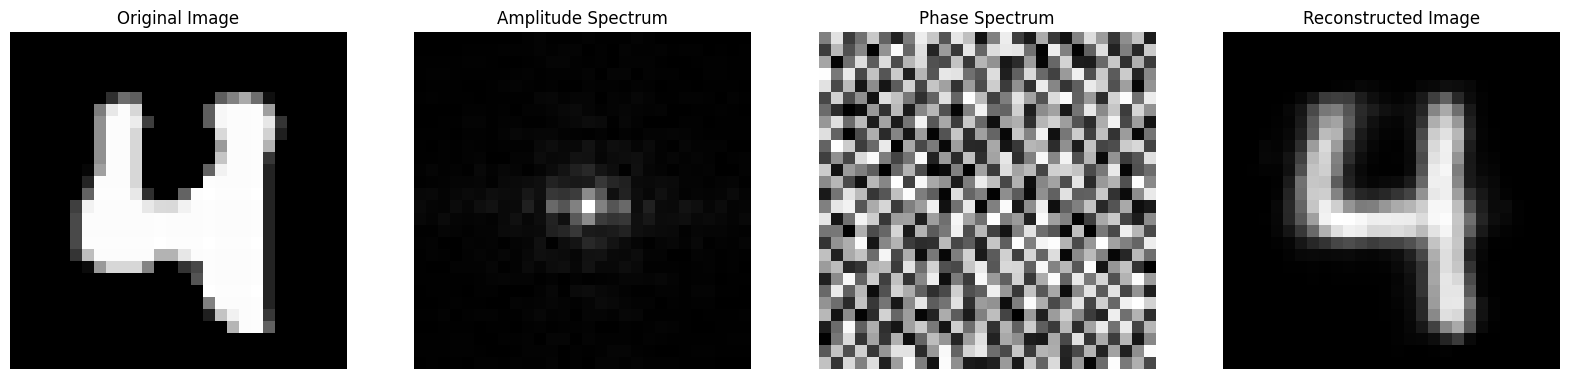

In [10]:
# Function to plot sample input amplitude spectrum, phase spectrum, and the reconstructed image
def plot_sample_and_reconstruction(model, params, data_loader):
    for batch in data_loader:
        # Extract the sample data
        original_image = batch['image'][0].numpy().reshape(28, 28)
        amp_spectrum = batch['amplitude'][0].numpy().reshape(28, 28)
        phase_spectrum = batch['phase'][0].numpy().reshape(28, 28)

        # Get the reconstruction from the model
        amp_input = jax.device_put(batch['amplitude'][0:1].numpy())
        phase_input = jax.device_put(batch['phase'][0:1].numpy())
        reconstructed_image = model.apply({'params': params}, amp_input, phase_input)
        reconstructed_image = jnp.array(reconstructed_image).reshape(28, 28)

        # Plot the original image, amplitude spectrum, phase spectrum, and reconstructed image
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Original image
        axes[0].imshow(original_image, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Amplitude spectrum
        axes[1].imshow(amp_spectrum, cmap='gray')
        axes[1].set_title('Amplitude Spectrum')
        axes[1].axis('off')

        # Phase spectrum
        axes[2].imshow(phase_spectrum, cmap='gray')
        axes[2].set_title('Phase Spectrum')
        axes[2].axis('off')

        # Reconstructed image
        axes[3].imshow(reconstructed_image, cmap='gray')
        axes[3].set_title('Reconstructed Image')
        axes[3].axis('off')

        plt.show()
        break  # Only show one sample for simplicity

# Plot a sample input and its reconstruction
plot_sample_and_reconstruction(model, state.params, test_loader)

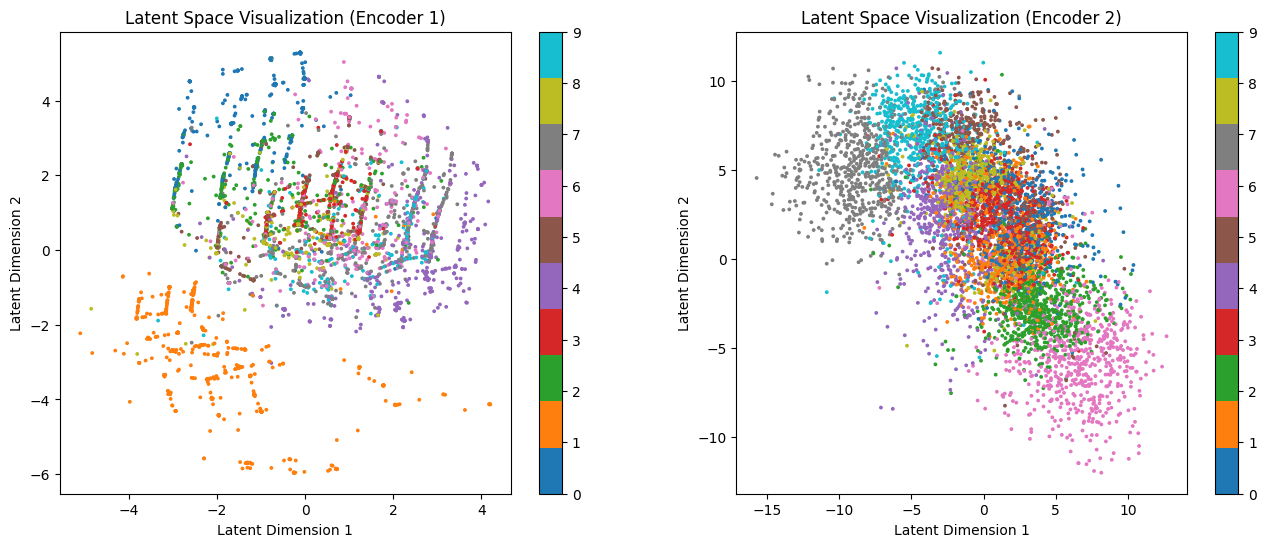

In [11]:
# Plotting function
def plot_latent(autoencoder, state, data_loader, num_batches=100):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Set figure size here (width, height) and create subplots

    scatter1 = scatter2 = None
    for i, batch in enumerate(data_loader):
        amp_batch = jnp.array(batch['amplitude'].numpy())
        phase_batch = jnp.array(batch['phase'].numpy())
        y_labels = batch['label'].numpy()
        
        # Apply encoder1 and encoder2 separately
        z1 = autoencoder.apply({'params': state.params}, amp_batch, method=Autoencoder.encode1)
        z2 = autoencoder.apply({'params': state.params}, phase_batch, method=Autoencoder.encode2)
        
        z1 = np.array(z1)  # Convert JAX array to NumPy array
        z2 = np.array(z2)  # Convert JAX array to NumPy array
        
        scatter1 = axes[0].scatter(z1[:, 0], z1[:, 1], c=y_labels, cmap='tab10', s=3)
        scatter2 = axes[1].scatter(z2[:, 0], z2[:, 1], c=y_labels, cmap='tab10', s=3)

        if i > num_batches:
            break

    # Plot settings for z1
    axes[0].set_xlabel('Latent Dimension 1')
    axes[0].set_ylabel('Latent Dimension 2')
    axes[0].set_title('Latent Space Visualization (Encoder 1)')
    
    # Plot settings for z2
    axes[1].set_xlabel('Latent Dimension 1')
    axes[1].set_ylabel('Latent Dimension 2')
    axes[1].set_title('Latent Space Visualization (Encoder 2)')
    
    # Add colorbars
    fig.colorbar(scatter1, ax=axes[0], orientation='vertical')
    fig.colorbar(scatter2, ax=axes[1], orientation='vertical')
    
    plt.show()  # Display the plot

# Assuming train_loader includes labels
plot_latent(model, state, train_loader)

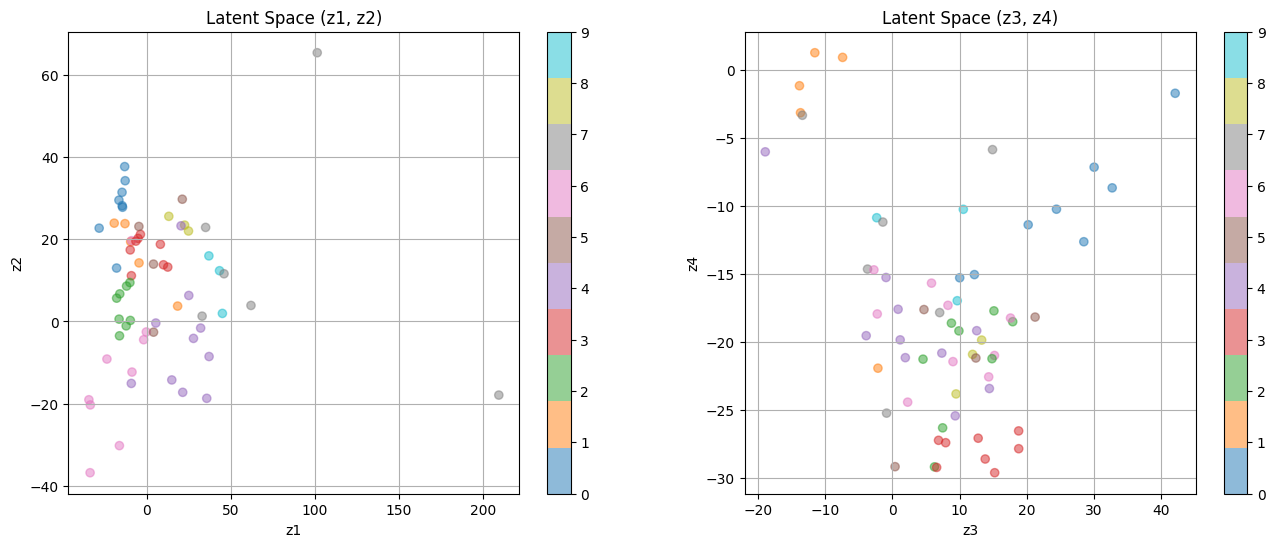

In [12]:
# Modified function to extract latent space and log_det
def extract_latent_and_logdet(state, data_loader, model):
    for batch in data_loader:
        amp_batch = jax.device_put(batch['amplitude'].numpy())
        phase_batch = jax.device_put(batch['phase'].numpy())
        labels = batch['label'].numpy()
        
        z, log_det = model.apply({'params': state.params}, amp_batch, phase_batch, method=model.get_latent_and_logdet)
        return z, log_det, labels  # Return labels as well

# Extract latent space and log_det after training
z, log_det, y = extract_latent_and_logdet(state, train_loader, model)



# Modified function to plot the latent space with color mapping
def plot_latent_space(z, y):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create subplots with 1 row and 2 columns

    # Plot for z[:, 0] and z[:, 1]
    scatter1 = axes[0].scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', alpha=0.5)
    axes[0].set_title('Latent Space (z1, z2)')
    axes[0].set_xlabel('z1')
    axes[0].set_ylabel('z2')
    axes[0].grid(True)

    # Plot for z[:, 2] and z[:, 3]
    scatter2 = axes[1].scatter(z[:, 2], z[:, 3], c=y, cmap='tab10', alpha=0.5)
    axes[1].set_title('Latent Space (z3, z4)')
    axes[1].set_xlabel('z3')
    axes[1].set_ylabel('z4')
    axes[1].grid(True)

    # Add colorbars
    fig.colorbar(scatter1, ax=axes[0], orientation='vertical')
    fig.colorbar(scatter2, ax=axes[1], orientation='vertical')

    plt.show()  # Display the plot

# Plot the latent space
plot_latent_space(z, y)

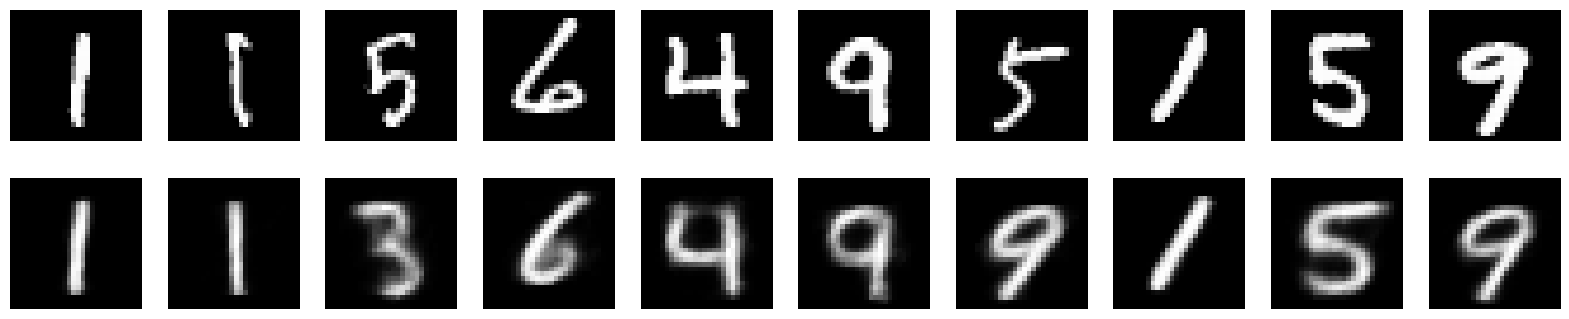

In [17]:
# Function to plot original and reconstructed images
def plot_reconstructions(model, params, test_loader):
    for batch in test_loader:
        x_batch = batch['image'].numpy()
        amp_batch = batch['amplitude'].numpy()
        phase_batch = batch['phase'].numpy()

        # Get reconstructions
        reconstructions = model.apply({'params': params}, jax.device_put(amp_batch), jax.device_put(phase_batch))
        reconstructions = jnp.array(reconstructions)

        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, 10, figsize=(20, 4))
        for i in range(10):
            # Original images
            axes[0, i].imshow(x_batch[i].reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            
            # Reconstructed images
            axes[1, i].imshow(reconstructions[i].reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
        
        plt.show()
        break  # Only show one batch for simplicity

# Plot some reconstructions
plot_reconstructions(model, state.params, test_loader)
